In [1]:
#More or less general imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import time

#Imports for Creating WebSky Maps 
import h5py    
import healpy as hp
from pixell import enmap,utils, reproject, bunch, curvedsky, enplot
import os, sys
import dill as dl
from scipy.interpolate import *
#Unit conversion
from astropy import units as u
from astropy.constants import k_B, h

#Creating Stamps
from astropy import wcs
from astropy.nddata import Cutout2D
import pickle as pk
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate
import ipyparallel as ipp
from mpi4py import MPI
from PIL import Image
from astLib import astWCS, astImages
from scipy import ndimage
from pixell.enmap import sky2pix
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import proj_plane_pixel_scales
from astroquery.skyview import SkyView
import astropy.io.fits as pyfits
from stamping_utils import autotiler, getTileCoordsDict, make_jpg, normalize_map, make_mask_wise, _make_jpg#, make_stamp
import glob
#, make_mask
%load_ext autoreload
%autoreload 2

%matplotlib inline
%matplotlib inline

# Creating the Map

In [2]:
# Gathers thumbnail for WebSky map given coords and a radius
def extract_thumbnail(webskymap, coords, r):
    return reproject.thumbnails(webskymap, coords, r=r)

def create_webmask(webskymap, coords, r):
    shape = webskymap.shape; wcs = webskymap.wcs
    mask = enmap.ones(shape, wcs)
    webmask = reproject.thumbnails(mask, coords, r=r)
    return webmask
    
def generate_coords():
    # Arccosine helper function
    def arccos_arange(start, finish, steps):
        """
        Converts an arange array of angles (in degrees) to their arccosine values in radians.
        Returns:
        Array of arccosine values in radians.
        """
        degrees_array = np.arange(start, finish, steps)
        radians_array = np.deg2rad(degrees_array)
        # (arccosine values will be between -1 and 1)
        cosine_values = np.cos(radians_array)
        y = np.arccos(cosine_values)
        return y
    
    # Coordinates
    x = np.arange(-np.pi, 181 * utils.degree, 1.5 * utils.degree)
    y = arccos_arange(-69, 69, 1.5)
    
    # Array of coordinates
    dec, ra = np.meshgrid(y, x)
    
    # Flatten the meshgrid arrays and combine them into pairs of positions
    coords = np.array([dec.ravel(), ra.ravel()]).T
    coords = np.unique(coords, axis=0)
    return coords

coords = generate_coords()

In [3]:
def create_websky_90map(freq): #Eventually have component, map freq, and other parameters
    
    #Constants
    TCMB = 2.726 #Kelvin
    TCMB_uK = 2.726e6 #micro-Kelvin
    hplanck=6.626068e-34 #MKS
    kboltz=1.3806503e-23 #MKS
    clight=299792458.0 #MKS

    #Unit conversion provided by Mat
    def dBnudT(nu_ghz):
        nu = 1.e9*np.asarray(nu_ghz)
        X = hplanck*nu/(kboltz*TCMB)
        return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK * 1e26

    def ItoDeltaT(nu_ghz):
        return 1./dBnudT(nu_ghz)

    #Arccosine
    def arccos_arange(start, finish, steps):
        """
        Converts an arange array of angles (in degrees) to their arccosine values in radians.
        Returns:
        Array of arccosine values in radians.
        """
        degrees_array = np.arange(start, finish, steps)
        radians_array = np.deg2rad(degrees_array)
        #(arccosine values will be between -1 and 1)
        cosine_values = np.cos(radians_array)
        y = np.arccos(cosine_values)
        return y
    
    #Coordinates
    x = np.arange(-np.pi, 181*utils.degree, 1.5*utils.degree)
    y=arccos_arange(-69,69,1.5)
    
    #Array of coordinates
    dec,ra=np.meshgrid(y, x)
    
    # Flatten the meshgrid arrays and combine them into pairs of positions
    coords = np.array([dec.ravel(), ra.ravel()]).T
    
    # Shape and WCS of the maps
    #For FullSky
    shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(0.5 / 60))
    
    #Access to WebSky Data
    path = "/mnt/welch/USERS/cwhitaker/maps/websky/"
    
    # CMB
    alm = hp.read_alm(path + 'lensed_alm.fits', hdu=(1, 2, 3))
    cmb_map = curvedsky.alm2map(alm.astype(np.complex128)[0, :], enmap.empty(shape, wcs, dtype=np.float32))
    
    # kSZ Effect
    ksz_map = hp.read_map(path + "ksz.fits")
    npix = ksz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    ksz_map = reproject.healpix2map(ksz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # tSZ Effect
    tsz_map = hp.read_map(path + "tsz_8192.fits")
    npix = tsz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    tsz_map = reproject.healpix2map(tsz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # Conversion factors
    tsz_093 = -4.2840 * 1e6
    tsz_145 = -2.7685 * 1e6
    tsz_225 = 3.1517 * 1e5
    
    # CIB
    cib_map = enmap.read_map(path + "cib_90.2_car.fits")
    
    # CIB conversions to temperature map in uK
    cib_093 = 4.6831 * 1e3
    cib_145 = 2.5947 * 1e3
    cib_217 = 2.0676 * 1e3
    cib_225 = 2.0716 * 1e3
    
    # Radio
    radio_map = enmap.read_map(path + "/map_radio_0.5arcmin_f90.2.fits")

    # Combine maps
    websky_f90map = radio_map * ItoDeltaT(freq) + cmb_map + cib_map * cib_093 + ksz_map + tsz_map * tsz_093
            
    return websky_f90map, wcs


In [4]:
#Global Constants
TCMB    = 2.726 #Kelvin
TCMB_uK = 2.726e6 #micro-Kelvin
hplanck = 6.626068e-34 #MKS
kboltz  = 1.3806503e-23 #MKS
clight  = 299792458.0 #MKS
#Access to WebSky Data
path    = "/mnt/welch/USERS/cwhitaker/maps/websky/"
    #Unit conversion provided by Mat
def dBnudT(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz)
    X = hplanck*nu/(kboltz*TCMB)
    return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK * 1e26

def ItoDeltaT(nu_ghz):
    return 1./dBnudT(nu_ghz)

def create_websky_150map(freq): #Eventually have component, map freq, and other parameters
    
    #Constants
    TCMB = 2.726 #Kelvin
    TCMB_uK = 2.726e6 #micro-Kelvin
    hplanck=6.626068e-34 #MKS
    kboltz=1.3806503e-23 #MKS
    clight=299792458.0 #MKS

    #Unit conversion provided by Mat
    def dBnudT(nu_ghz):
        nu = 1.e9*np.asarray(nu_ghz)
        X = hplanck*nu/(kboltz*TCMB)
        return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK * 1e26

    def ItoDeltaT(nu_ghz):
        return 1./dBnudT(nu_ghz)

    #Arccosine
    def arccos_arange(start, finish, steps):
        """
        Converts an arange array of angles (in degrees) to their arccosine values in radians.
        Returns:
        Array of arccosine values in radians.
        """
        degrees_array = np.arange(start, finish, steps)
        radians_array = np.deg2rad(degrees_array)
        #(arccosine values will be between -1 and 1)
        cosine_values = np.cos(radians_array)
        y = np.arccos(cosine_values)
        return y
    
    #Coordinates
    x = np.arange(-np.pi, 181*utils.degree, 1.5*utils.degree)
    y=arccos_arange(-69,69,1.5)
    
    #Array of coordinates
    dec,ra=np.meshgrid(y, x)
    
    # Flatten the meshgrid arrays and combine them into pairs of positions
    coords = np.array([dec.ravel(), ra.ravel()]).T
    
    # Shape and WCS of the maps
    #For FullSky
    shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(0.5 / 60))
    
    #Access to WebSky Data
    path = "/mnt/welch/USERS/cwhitaker/maps/websky/"
    
    # CMB
    alm = hp.read_alm(path + 'lensed_alm.fits', hdu=(1, 2, 3))
    cmb_map = curvedsky.alm2map(alm.astype(np.complex128)[0, :], enmap.empty(shape, wcs, dtype=np.float32))
    
    # kSZ Effect
    ksz_map = hp.read_map(path + "ksz.fits")
    npix = ksz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    ksz_map = reproject.healpix2map(ksz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # tSZ Effect
    tsz_map = hp.read_map(path + "tsz_8192.fits")
    npix = tsz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    tsz_map = reproject.healpix2map(tsz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # Conversion factors
    tsz_093 = -4.2840 * 1e6
    tsz_145 = -2.7685 * 1e6
    tsz_225 = 3.1517 * 1e5
    
    # CIB
    cib_map = enmap.read_map(path + "cib_153_car.fits")
    # CIB conversions to temperature map in uK
    cib_093 = 4.6831 * 1e3
    cib_145 = 2.5947 * 1e3
    cib_217 = 2.0676 * 1e3
    cib_225 = 2.0716 * 1e3
    
    # Radio
    radio_map = enmap.read_map(path + "/map_radio_0.5arcmin_f143.0.fits")

    # Combine maps
    websky_f150map = radio_map * ItoDeltaT(freq) + cmb_map + cib_map * cib_145 + ksz_map + tsz_map * tsz_145
            
    return websky_f150map, wcs

In [5]:
def create_websky_220map(freq): #Eventually have component, map freq, and other parameters
    # Shape and WCS of the maps
    #For FullSky
    shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(0.5 / 60))
    
    #Access to WebSky Data
    path = "/mnt/welch/USERS/cwhitaker/maps/websky/"
    
    # CMB
    alm = hp.read_alm(path + 'lensed_alm.fits', hdu=(1, 2, 3))
    cmb_map = curvedsky.alm2map(alm.astype(np.complex128)[0, :], enmap.empty(shape, wcs, dtype=np.float32))
    
    # kSZ Effect
    ksz_map = hp.read_map(path + "ksz.fits")
    npix = ksz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    ksz_map = reproject.healpix2map(ksz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # tSZ Effect
    tsz_map = hp.read_map(path + "tsz_8192.fits")
    npix = tsz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    tsz_map = reproject.healpix2map(tsz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # Conversion factors
    tsz_093 = -4.2840 * 1e6
    tsz_145 = -2.7685 * 1e6
    tsz_217 = -2.1188 * 1e4
    tsz_225 = 3.1517 * 1e5
    
    # CIB
    cib_map = enmap.read_map(path + "cib_217_car.fits")
    
    # CIB conversions to temperature map in uK
    cib_093 = 4.6831 * 1e3
    cib_145 = 2.5947 * 1e3
    cib_217 = 2.0676 * 1e3
    cib_225 = 2.0716 * 1e3
    
    # Radio
    radio_map = enmap.read_map(path + "/map_radio_0.5arcmin_f217.0.fits")
    # Combine maps
    websky_f220map = radio_map * ItoDeltaT(freq) + cmb_map + cib_map * cib_217 + ksz_map + tsz_map * tsz_217
            
    return websky_f220map, wcs


In [6]:
webskyf90map, wcs = create_websky_90map(90.2)

In [16]:
webskyf90map.shape

(21601, 43200)

In [7]:
webskyf150map, wcs = create_websky_150map(143)

In [8]:
t3 = time.time()
webskyf220map, wcs = create_websky_220map(217)
t4 = time.time()
print(t4-t3)

269.0733485221863


In [9]:
t0 = time.time()
websky_f150_map = extract_thumbnail(webskyf150map, coords[1225], r=2*utils.degree)
t1 = time.time()
print(t1-t0)

0.5353245735168457


In [10]:
coords.shape
#webmask = create_webmask(webskymap, coords[0], r=2*utils.degree)

(11327, 2)

In [25]:
r = 2*utils.degree
ra, dec = coords[3450]

ramin, decmin = ra-r, dec-r
ramax, decmax = ra+r, dec+r
new_box = np.array([[decmin, ramin],[decmax, ramax]])
        
box = np.array([[decmin, ramin],[decmax, ramax]])
print(box)

[[-1.18682389  0.33161256]
 [-1.11701072  0.40142573]]


In [26]:
ra, dec

(0.3665191429188092, -1.1519173063162462)

In [27]:
cur_map = enmap.read_map("/mnt/welch/USERS/cwhitaker/maps/websky/Fullwebsky_f090_map.fits", box=box)

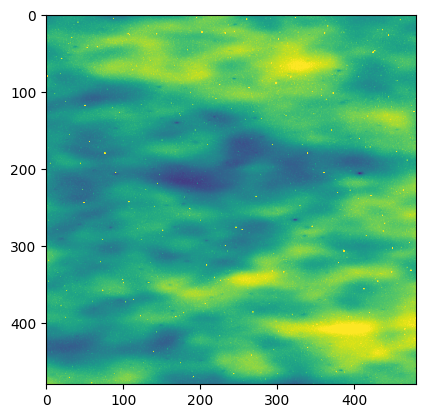

In [28]:
lims=300
plt.imshow(cur_map,vmin=-lims, vmax=lims)

In [ ]:
lims=300
plt.imshow(w1100ebsky_90_map,vmin=-lims, vmax=lims)
#plt.savefig('w9090')

In [ ]:
cue_map=enmap.read_map('w20ebsky_f090_map.fits', box=box)

In [ ]:
lims=300
plt.imshow(cue_map,vmin=-lims, vmax=lims)

In [ ]:
w20ebsky_090_map = extract_thumbnail(webskyf90map, coords[20], r=2*utils.degree)

In [ ]:
lims=300
plt.imshow(w20ebsky_090_map,vmin=-lims, vmax=lims)

### Reading the file

In [ ]:
omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [ ]:
#Access to the WebSky data
#path = "/mnt/welch/USERS/jorlo/maps/websky/"
#Access to CIB and other WebSky data
path = "/mnt/welch/USERS/cwhitaker/maps/websky/"

In [ ]:
cluster_catalog=open(path + 'halos.pksc')
N = np.fromfile(cluster_catalog,count=3,dtype=np.int32)[0]
# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
#N = 10
catalog=np.fromfile(cluster_catalog,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))
x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc
#print(catalog)

In [ ]:
dec,ra = hp.vec2ang(np.column_stack((x,y,z))) # in radians
# Constants
rho      = 2.775e11*omegam*h**2 # Msun/Mpc^3
# this is M200m (mean density 200 times mean) in Msun
M        = 4*np.pi/3.*rho*R**3
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
redshift = zofchi(chi)

In [ ]:
print(catalog)

In [ ]:
#Limit to how bright/massive the clusters can be
cluster_cut = 2.0e14
#also figure out how to convert to masses in here. I think M is mass
cluster_flags = np.where((M >= cluster_cut))[0]
#Limit on parameters of clusters
M            = M[cluster_flags]
redshift     = redshift[cluster_flags]
cluster_decs = dec[cluster_flags]
cluster_ras  = ra[cluster_flags]
#yc           = yc[cluster_flags]

In [ ]:
#make_mask is defined in the stamping file but I've added this one for testing
def make_mask(image, catalog, box, cur_wcs, size = 2.4, jpg=False):
    #Function which makes masks corresponding to clusters in a image. 
    if jpg: 
        mask = np.zeros(image[...,0].shape)

    else:
        mask = np.zeros(image[0].shape)

    min_ra, max_ra, min_dec, max_dec = box[0][0], box[0][1], box[1][0], box[1][1] 
    x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
    R  = catalog[:,6] # Mpc
    dec,ra = hp.vec2ang(np.column_stack((x,y,z))) # in radians
    h  = 0.68
    rho = 2.775e11*omegam*h**2 # Msun/Mpc^3
    
# this is M200m (mean density 200 times mean) in Msun
    M  = 4*np.pi/3.*rho*R**3
    #Limit to how bright/massive the clusters can be
    cluster_cut = 2.0e14
#also figure out how to convert to masses in here. I think M is mass
    cluster_flags = np.where((M >= cluster_cut))[0]
#Limit on parameters of clusters
    M            = M[cluster_flags]
    #redshift     = redshift[cluster_flags]
    cluster_decs = dec[cluster_flags]
    cluster_ras  = ra[cluster_flags]
   
    in_image = np.where((min_ra < cluster_ras) & (cluster_ras < max_ra) & (min_dec < cluster_decs) & (cluster_decs < max_dec))[0]

    if len(in_image) == 0:
        return mask
 
    for i in range(len(in_image)):
        cur_cluster = in_image[i]
        cur_center = SkyCoord(cluster_ras[cur_cluster], cluster_decs[cur_cluster], unit = "deg")
        x,y = skycoord_to_pixel(cur_center, cur_wcs)
        
        x,y = np.round(x), np.round(y)
        #print(x,y)
        pix_size = proj_plane_pixel_scales(cur_wcs)[0] * 60

        r = size/2/pix_size
        
        xx, yy = np.meshgrid(np.linspace(0, mask.shape[1]-1, mask.shape[1]), np.linspace(0, mask.shape[0]-1, mask.shape[0]))    
        r_mask = (xx-x)**2 + (yy-y)**2 < r**2

        mask += r_mask*(i+1)
        
        doubled_mask = mask > i+1 #Un-double counts areas where clusters overlap
        mask -= doubled_mask*(i+1)
    
    return mask

In [ ]:
#Also for testing
def make_stamp(path, box, freqs, normalize = True):
    freqs = sorted(freqs)
    files = glob.glob(path)

    path = [path for path in files if freqs[0] in path]
    if len(path) > 1:
           raise PathError("Err: multiple paths match freq {}".format(freq))
    base_map = enmap.read_map(path[0], box = box)
    #print(base_map)
    print(base_map.shape)
    wcs = base_map.wcs
    cur_map = base_map[0]
    #print(cur_map.shape)
    if normalize:
        cur_map = normalize_map(cur_map)
    
    freq_maps = np.empty([len(freqs), cur_map.shape[0], cur_map.shape[1]]) #Gonna have to roll this in the loader
    freq_maps[0] = cur_map

    for i, freq in enumerate(freqs):
        if i == 0: continue 
        path = [path for path in files if freq in path]
        if len(path) > 1:
            raise PathError("Err: multiple paths match freq {}".format(freq))
        
        cur_map = enmap.read_map(path[0], box = box)
        wcs = cur_map.wcs
        cur_map = cur_map[0] #select temperature channel
        if normalize:
            cur_map = normalize_map(cur_map)
        if type(cur_map) == int: #error handling from normalize_map
            return -1
        freq_maps[i] = cur_map
        print(base_map[:].shape)
        print(freq_maps.shape)
 
    base_map[:] = freq_maps
    return base_map, wcs

In [ ]:
#Testing as well
#def make_stamp(path, box, freqs, normalize = True):
path = '/mnt/welch/USERS/cwhitaker/maps/websky/w0ebsky_f*_map.fits'
r = 2*utils.degree
freqs = ["090", "150", "220"]
freqs = sorted(freqs)
files = glob.glob(path)
#for coord in coords:
    #dec, ra = coord
ramin, decmin = -r, -r
ramax, decmax = r, r
in_image = np.where((ramin < cluster_ras) & (cluster_ras < ramax) & (decmin < cluster_decs) & (cluster_decs < decmax))[0]
if ramax < ramin:
    ramin -= 360 * utils.degree
        
box = np.array([[decmin, ramin],[decmax, ramax]])
path = [path for path in files if freqs[0] in path]
if len(path) > 1:
        raise PathError("Err: multiple paths match freq {}".format(freq))
#print(path[0])
base_map = enmap.read_map(path[0], box = box)
print(base_map.shape)
wcs = base_map.wcs
cur_map = base_map
print(cur_map.shape)
#if normalize:
    #cur_map = normalize_map(cur_map)

freq_maps = np.empty([len(freqs), cur_map.shape[0], cur_map.shape[1]]) #Gonna have to roll this in the loader
#print(freq_maps)
freq_maps[0] = cur_map
#print(cur_map)
for i, freq in enumerate(freqs):
    if i == 0: continue 
    path = [path for path in files if freq in path]
    if len(path) > 1:
        raise PathError("Err: multiple paths match freq {}".format(freq))
        
    cur_map = enmap.read_map(path[0], box = box)
    wcs = cur_map.wcs
    cur_map = cur_map[0] #select temperature channel
    #if normalize:
        #cur_map = normalize_map(cur_map)
    #if type(cur_map) == int: #error handling from normalize_map
       # return -1
    freq_maps[i] = cur_map
    #print(cur_map.shape)
print(freq_maps.shape)
base_map = freq_maps
print(base_map.shape)

In [ ]:
freqs = ["090", "150", "220"]
#Make jpg of box
#Tuple issue is from the websky map not originally being (3, 961, 961)

from stamping_utils import make_stamp
jpg, cur_wcs = make_stamp('/mnt/welch/USERS/cwhitaker/maps/websky/w90ebsky_f*_map.fits', box, freqs, normalize= False)
mask = make_mask(jpg, catalog, box, cur_wcs, size = 2.4)